In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter

import joblib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope
from modules.Utils.classes.scalers import CustomMinMaxScaler, CustomStandardScaler

In [27]:
SYMBOL= 'AAVE'
df = loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv')
df_BTC = loadFromDB(f'../backtest_tools/database/database/Binance/1h/BTC-USDT.csv')
df_BTC.head()

Total records : 14725 rows
Total records : 42336 rows


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800


In [28]:
df_BTC = df_BTC.loc[df.index[0]:]
df['Open_BTC'] = df_BTC.Open
df['High_BTC'] = df_BTC.High
df['Low_BTC'] = df_BTC.Low
df['Close_BTC'] = df_BTC.Close
df['Volume_BTC'] = df_BTC.Volume
df = computeLaggingLinearRegression(df,window=40,filter_ceof=True, derivative=False,)
df = computeFutureLinearRegression(df,window=15,filter_ceof=True, derivative=True,)
df = computeTrixIndicator(df)
df = addIndicators(df,derivative=True,double_derivative=True,b_engulfings=True)
df = computeMASlope(df).dropna()
df = computeRSI_VWAP(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,Open_BTC,High_BTC,Low_BTC,Close_BTC,...,OVB,OVB_EMA200,EVM,Bullish_engulfing,Bearish_engulfing,Slope,Acceleration,Angle,MA_Slope,RSI_VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-29 10:00:00,31.182,31.408,31.055,31.372,7973.174,1603962000,13123.96,13208.77,13120.00,13190.11,...,-220477.131,-79350.210443,-1523.007023,0.0,0.0,0.181,1.028,66.0,22.191301,0.0
2020-10-29 11:00:00,31.373,31.373,30.465,30.526,16090.284,1603965600,13190.10,13199.00,13041.18,13097.51,...,-236567.415,-80914.560737,-1763.486586,0.0,1.0,-0.846,-1.027,60.0,22.354531,0.0
2020-10-29 12:00:00,30.506,30.506,28.984,29.007,28640.239,1603969200,13097.51,13171.86,13050.00,13052.06,...,-265207.654,-82748.322859,-6238.872518,0.0,0.0,-1.519,-0.673,52.0,22.499446,0.0
2020-10-29 13:00:00,29.018,29.693,28.124,29.502,17454.297,1603972800,13051.68,13145.36,12920.77,13130.30,...,-247753.357,-84390.163994,-7519.457816,0.0,0.0,0.495,2.014,50.0,22.627331,0.0
2020-10-29 14:00:00,29.541,30.419,29.380,30.244,8260.379,1603976400,13131.03,13250.00,13093.87,13232.00,...,-239492.978,-85933.475577,12464.912324,0.0,0.0,0.742,0.247,50.0,22.765850,0.0


Period : [2021-11-24 12:00:00] -> [2022-06-20 20:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 423312.14 $
Performance vs US Dollar : 42231.21 %
Buy and Hold Performence : -77.15 %
Performance vs Buy and Hold : -54839.52 %
Best trade : +22.07 %, the 2022-03-29 18:00:00
Worst trade : -9.86 %, the 2022-01-21 23:00:00
Worst drawBack : -11.0 %
Total fees :  17820.79 $

----- Trades Informations -----
Total trades on period : 223
Number of positive trades : 164
Number of negative trades :  59
Trades win rate ratio : 73.54 %
Average trades performance : 2.93 %
Average positive trades : 4.72 %
Average negative trades : -2.04 %

----- Plot -----


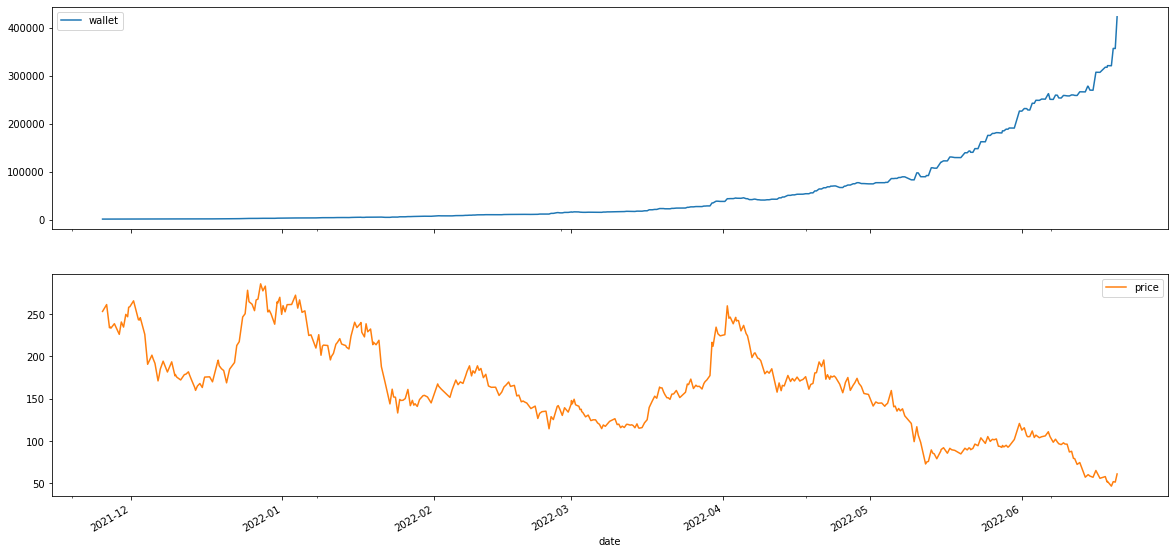

In [29]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.F_MLR_coefs_filtered_diff>0 and row.F_MLR_coefs_filtered_diff<0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.F_MLR_coefs_filtered_diff<0 and row.F_MLR_coefs_filtered_diff>0 else False

strategyTester(df.iloc[-5000:],buyCondition,sellCondition)

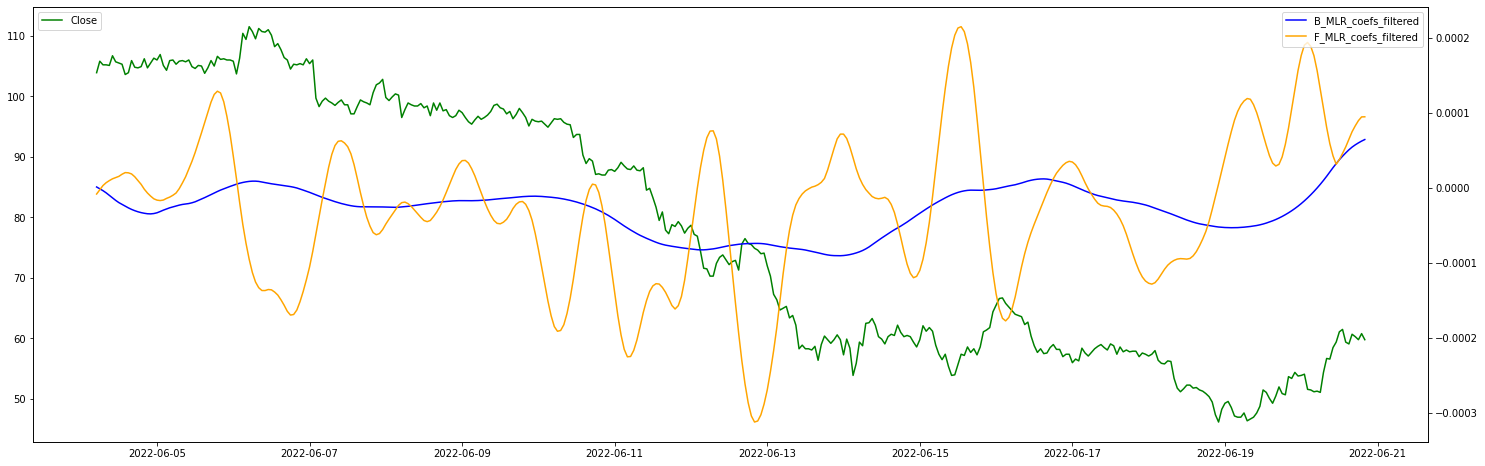

In [30]:
window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.Close, color='green',label='Close')
ax = ax_left.twinx()
ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

# Normalization

In [31]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'Open_BTC',
       'High_BTC', 'Low_BTC', 'Close_BTC', 'Volume_BTC', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'F_MLR_coefs', 'F_MLR_coefs_filtered',
       'F_MLR_coefs_filtered_diff', 'F_MLR_coefs_filtered_strat', 'Trix',
       'Trix_histo', 'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX',
       'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'EVM', 'Bullish_engulfing',
       'Bearish_engulfing', 'Slope', 'Acceleration', 'Angle', 'MA_Slope',
       'RSI_VWAP'],
      dtype='object')

In [32]:
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Open_BTC',
       'High_BTC', 'Low_BTC', 'Close_BTC', 'Volume_BTC', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'Trix',
       'Trix_histo', 'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX',
       'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'EVM', 'Bullish_engulfing',
       'Bearish_engulfing', 'Slope', 'Acceleration', 'Angle', 'MA_Slope',
       'RSI_VWAP']].values)

joblib.dump(x_scaler,f'./models/std_scaler_{SYMBOL}.save')

['./models/std_scaler_AAVE.save']

# Decorrelation

In [ ]:
import seaborn as sb
corr = df.corr()
fig, ax = plt.subplots(1, figsize=(25,8))

sb.heatmap(corr, cmap="Blues", annot=True, ax=ax)

In [ ]:
from sklearn.decomposition import PCA

decomposer = PCA()
all_component_decorr = decomposer.fit_transform(x_scaled)

In [ ]:
var = decomposer.explained_variance_
var_ratio = decomposer.explained_variance_ratio_
var_ratio_cumcum = np.cumsum(var_ratio)
df_variances = pd.DataFrame(data={
    "Variance":var,
    "Variance_ratio":var_ratio,
    "Variance_ratio_cum":var_ratio_cumcum
},index=[i for i in ['Open', 'High', 'Low', 'Close', 'Volume',  'High_Low_diff', 'EMA20', 'EMA50', 'EMA100',
       'EMA200', 'MACD', 'Stoch_RSI', 'Vortex', 'Bollinger_low',
       'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB', 'OVB_EMA200', 'TRIX','TRIX_HISTO', 'EVM']])
df_variances.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(25,10))

ax.plot(df_variances.Variance_ratio_cum,color='red')
ax.axhline(y=0.99,linestyle='--',color='black')
ax_2 = ax.twinx()
ax_2.hist(df_variances.Variance,alpha=0.4)

We need only 8 components to use the dataset with 95% variance

In [ ]:
decorrelator = PCA(n_components=11)
useful_component_decorr = decorrelator.fit_transform(x_scaled)
useful_component_decorr

# Predictions

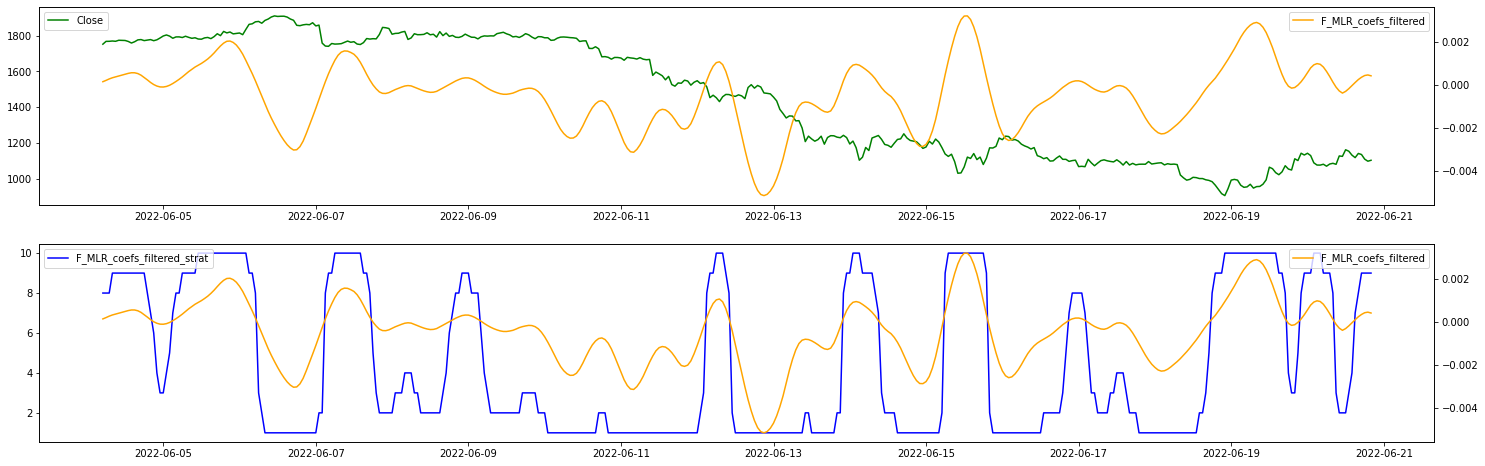

In [39]:
window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(2, figsize=(25,8))

ax_left[0].plot(df_see.Close, color='green',label='Close')
ax = ax_left[0].twinx()
#ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[0].legend(loc="upper left")
ax.legend(loc="upper right")
ax_left[1].plot(df_see.F_MLR_coefs_filtered_strat, color='blue',label='F_MLR_coefs_filtered_strat')
ax = ax_left[1].twinx()
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[1].legend(loc="upper left")
ax.legend(loc="upper right")

## Classification

### Bins Classficiation

In [6]:
WINDOW=20

X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn
y_clf = np.array([df.F_MLR_coefs_filtered_strat.iloc[i] for i in range(WINDOW,len(df))]) #Classification

X_train, X_test, y_train, y_test = train_test_split(X,y_clf,test_size=0.2, shuffle=True)

In [ ]:
model = RandomForestClassifier(n_estimators=120,criterion='entropy',verbose=1,n_jobs=4)
model.fit(X_train,y_train)

joblib.dump(model, f"./models/random_forect_clf_1h_{SYMBOL}.save")

In [ ]:
y_clf_pred = model.predict(X)
print(model.score(X_test,y_test))

## Regression

In [33]:
WINDOW=20

X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn
X_tf = np.array([x_scaled[i-WINDOW:i] for i in range(WINDOW,len(x_scaled))]) # Tensorflow
#X = np.array([useful_component_decorr[i:i+WINDOW].reshape(1,-1)[0] for i in range(len(useful_component_decorr)-WINDOW)]) # Sklearn + PCA 8

y_reg = MinMaxScaler((-1,1)).fit_transform(np.array([df.F_MLR_coefs_filtered.iloc[i] for i in range(WINDOW,len(df))]).reshape(-1, 1)) #Regression

X_train, X_test, y_train, y_test = train_test_split(X,y_reg,test_size=0.2, shuffle=True)

In [ ]:
model = RandomForestRegressor(verbose=1,n_jobs=4)
model.fit(X_train,y_train)
joblib.dump(model, f"./models/random_forect_reg_1h_{SYMBOL}.save") 

In [ ]:
y_reg_pred = model.predict(X)
print(model.score(X_test,y_test))

## Correction

In [34]:
reg= joblib.load('./models/random_forest_reg_1h_all_8_cpu.save')
y_reg_pred = reg.predict(X)
clf = joblib.load('./models/random_forest_clf_1h_all_8_cpu.save')
y_clf_pred = clf.predict(X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:    1.3s finished


In [9]:
import tensorflow as tf
from tensorflow import keras


2022-06-24 12:06:10.702383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 12:06:10.702547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
new_model = tf.keras.models.load_model('./models/lstm_conv_dense_all.h5')
y_nn_pred = new_model.predict(X_tf)
y_nn_pred

array([[ 0.07059038],
       [ 0.06726287],
       [ 0.06614101],
       ...,
       [-0.01079955],
       [-0.00267027],
       [-0.00100728]], dtype=float32)

In [36]:
model = RandomForestRegressor(verbose=1,n_jobs=4)
model.fit(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1),y_reg)
print(model.score(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1),y_reg))
y_f = model.predict(np.stack((y_clf_pred,y_reg_pred,y_nn_pred.reshape(1,-1)[0]),axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.8661749467188621


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


In [ ]:
joblib.dump(model, f"./models/random_forect_corrector_1h_{SYMBOL}.save") 

In [37]:
df['y_final'] = np.nan
df['y_final'].iloc[WINDOW:]=y_f
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Timestamp,Open_BTC,High_BTC,Low_BTC,Close_BTC,...,OVB_EMA200,EVM,Bullish_engulfing,Bearish_engulfing,Slope,Acceleration,Angle,MA_Slope,RSI_VWAP,y_final
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30 06:00:00,28.000,29.430,27.921,29.056,28235.764,1604034000,13420.87,13497.74,13174.52,13181.57,...,-110715.080837,3230.620925,0.0,0.0,1.066,0.887,38.0,24.408442,0.000000,0.192723
2020-10-30 07:00:00,29.068,29.634,29.047,29.105,5243.838,1604037600,13181.56,13293.80,13146.48,13201.99,...,-111932.343983,7444.070545,0.0,0.0,0.049,-1.017,41.0,24.501341,0.000000,0.188155
2020-10-30 08:00:00,29.105,29.318,28.608,29.120,7126.446,1604041200,13201.99,13261.22,13115.00,13218.96,...,-113066.585148,-3760.991103,0.0,0.0,0.015,-0.034,40.0,24.586970,0.000000,0.186425
2020-10-30 09:00:00,29.182,30.943,28.996,29.795,11630.859,1604044800,13218.96,13338.85,13188.91,13242.48,...,-114073.810390,16848.759838,0.0,0.0,0.675,0.660,42.0,24.699966,0.674141,0.185827
2020-10-30 10:00:00,29.751,30.087,28.955,29.727,11436.222,1604048400,13242.49,13298.43,13147.66,13277.05,...,-115184.806744,-4439.420641,0.0,0.0,-0.068,-0.743,44.0,24.795736,0.661641,0.180648


In [ ]:
X = np.array([x_scaled[i-WINDOW:i].reshape(1,-1)[0] for i in range(WINDOW,len(x_scaled))]) # Sklearn

reg = joblib.load('./models/random_forest_reg_1h_ETH.save')
y_reg_pred = reg.predict(X)
clf = joblib.load('./models/random_forest_clf_1h_ETH.save')
y_clf_pred = clf.predict(X)
corrector = joblib.load('./models/random_forest_corrector_1h_ETH.save')
y_final = corrector.predict(np.stack((y_clf_pred,y_reg_pred),axis=1))

In [38]:
df['y_final_filtered'] = np.nan 
df['y_final_filtered'] = savgol_filter(df.y_final,15,2,mode='nearest')
df['y_final_filtered_diff']  = df['y_final_filtered'].diff(2)

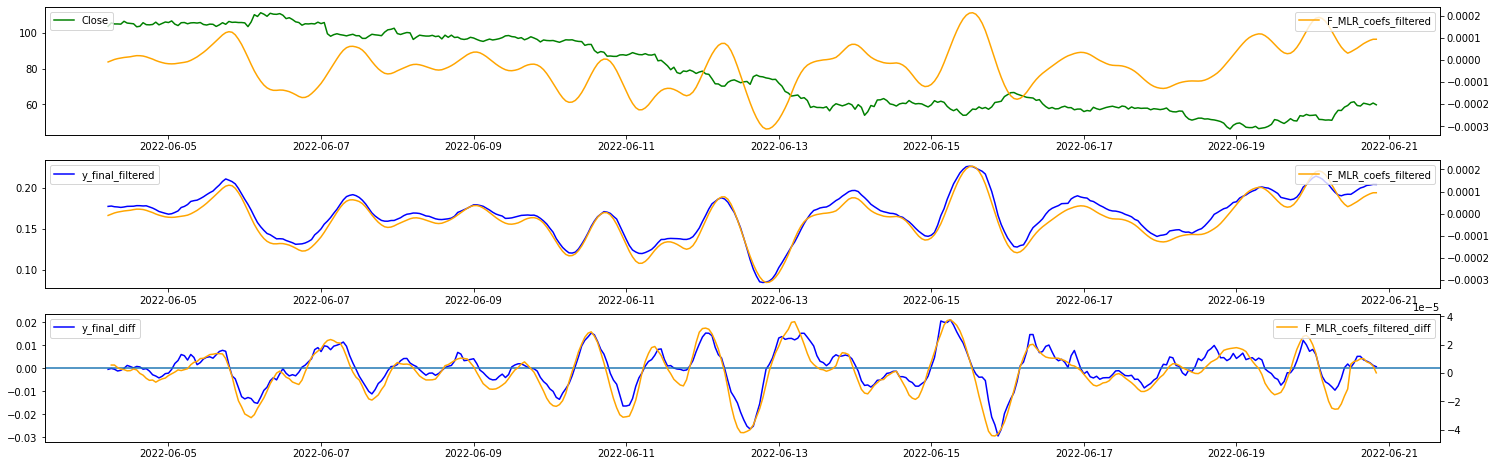

In [39]:
window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(3, figsize=(25,8))

ax_left[0].plot(df_see.Close, color='green',label='Close')
ax = ax_left[0].twinx()
#ax.plot(df_see.B_MLR_coefs_filtered, color='blue',label='B_MLR_coefs_filtered')
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[0].legend(loc="upper left")
ax.legend(loc="upper right")
ax_left[1].plot(df_see.y_final_filtered, color='blue',label='y_final_filtered')
ax = ax_left[1].twinx()
ax.plot(df_see.F_MLR_coefs_filtered, color='orange',label='F_MLR_coefs_filtered')
ax_left[1].legend(loc="upper left")
ax.legend(loc="upper right")

ax_left[2].plot(df_see.y_final_filtered_diff, color='blue',label='y_final_diff')
ax = ax_left[2].twinx()
ax.plot(df_see.F_MLR_coefs_filtered.diff(), color='orange',label='F_MLR_coefs_filtered_diff')
ax_left[2].axhline(y=0)
ax_left[2].legend(loc="upper left")
ax.legend(loc="upper right")

Period : [2021-11-24 12:00:00] -> [2022-06-20 20:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 511510.8 $
Performance vs US Dollar : 51051.08 %
Buy and Hold Performence : -77.15 %
Performance vs Buy and Hold : -66271.71 %
Best trade : +22.07 %, the 2022-03-29 18:00:00
Worst trade : -10.43 %, the 2022-01-21 23:00:00
Worst drawBack : -11.0 %
Total fees :  25815.37 $

----- Trades Informations -----
Total trades on period : 250
Number of positive trades : 176
Number of negative trades :  74
Trades win rate ratio : 70.4 %
Average trades performance : 2.7 %
Average positive trades : 4.5 %
Average negative trades : -1.59 %

----- Plot -----


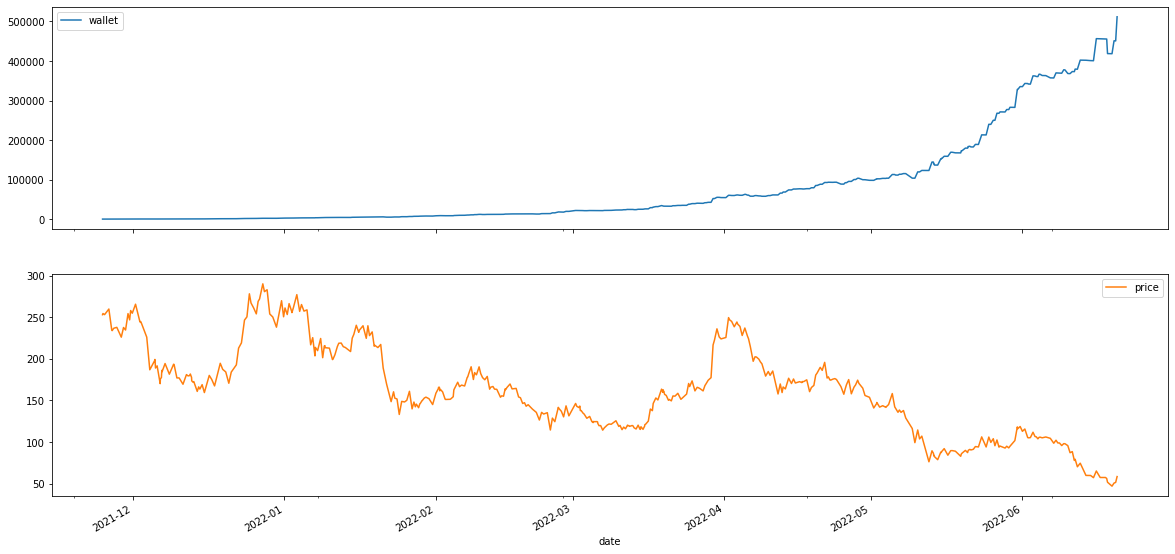

In [40]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.y_final_filtered_diff>0 and row.y_final_filtered_diff<0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.y_final_filtered_diff<0 and row.y_final_filtered_diff>0 else False

strategyTester(df.iloc[-5000:],buyCondition,sellCondition)